<a href="https://colab.research.google.com/github/AlbertoRomanRamosRodriguez/Tesis-de-Grado/blob/main/APTOS_EYEPACS_grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grading Diabetic Retinopath with APTOS and EYEPACS

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from shutil import copy, unpack_archive,move
from google.colab import drive

import matplotlib.pyplot as plt
import pandas as pd
import os

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
class KaggleJSONFile:
  def __init__(self, folder_path:str):
    self.__folder_location = folder_path
    self.__filename = 'kaggle.json'
    self.__destination_path = '/root/.kaggle'

  def setup(self):
    p_orig = os.path.join(self.__folder_location, self.__filename)
    p_dest = os.path.join(self.__destination_path, self.__filename)

    os.mkdir(self.__destination_path)
    copy(p_orig, p_dest)

    !chmod 600 {p_dest}


In [ ]:
k = KaggleJSONFile('/gdrive/MyDrive/Kaggle_keys')
k.setup()

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection
!kaggle datasets download -d mariaherrerot/eyepacspreprocess

100% 9.51G/9.51G [07:31<00:00, 21.1MB/s]
100% 9.51G/9.51G [07:31<00:00, 22.6MB/s]
100% 6.04G/6.04G [05:39<00:00, 24.2MB/s]
100% 6.04G/6.04G [05:39<00:00, 19.1MB/s]


In [ ]:
zipfiles = [f for f in os.listdir('/content') if '.zip' in f]

def unpack(filename:str):
  f = os.path.join('/content', filename)

  unpack_archive(
      filename = f,
      extract_dir='/content'
  )

  return os.path.join('/content',filename.split('.')[0])

dataset_dirs = [unpack(z) for z in zipfiles]

In [ ]:
train_csv_files = [f for f in os.listdir('/content') if '.csv' in f and 'train' in f]
dataframes = [pd.read_csv(csv) for csv in train_csv_files]

name_mappings = {
    'id_code': 'image',
    'diagnosis': 'level'
}


for d, extension in zip(dataframes, ['.png', '.jpeg']):
  d.rename(columns=name_mappings, inplace=True)
  d['image'] = d['image']+ extension
  display(d.head())

classes = range(5)
orig_ds = pd.concat(dataframes)
orig_ds.reset_index(inplace=True)
orig_ds.iloc[0,:]

,image,level
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


index                   0
image    000c1434d8d7.png
level                   2
Name: 0, dtype: object

level
0    27607
1     2808
2     6287
3     1065
4     1003
Name: image, dtype: int64

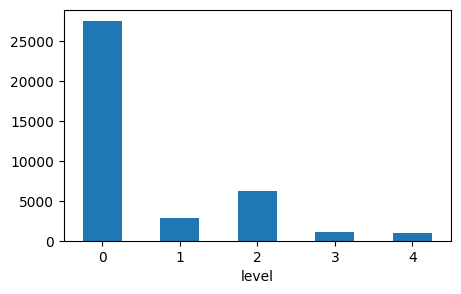

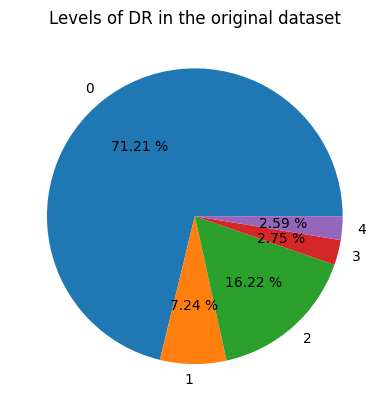

In [ ]:
def reset_path(directory:str):
    """
    Deletes an existing directory and re-creates it

    - directory: path to directory
    """
    if os.path.exists(directory):
        !rm -r {directory}
    os.mkdir(directory)

DB_PATH = './DB'
reset_path(DB_PATH)

display(orig_ds.groupby('level')['image'].count())

dfp = orig_ds.pivot_table(
    index='level',
    aggfunc='size'
)
dfp.plot(
    kind='bar',
    figsize=(5,3),
    rot=0
)
plt.show()

classes = 5
plt.pie([orig_ds.loc[orig_ds['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the original dataset")
img_path = os.path.sep.join([DB_PATH, 'distribution.png'])
plt.savefig(img_path)
plt.show()

level
0    1000
1    1000
2    1000
3    1000
4    1000
Name: image, dtype: int64

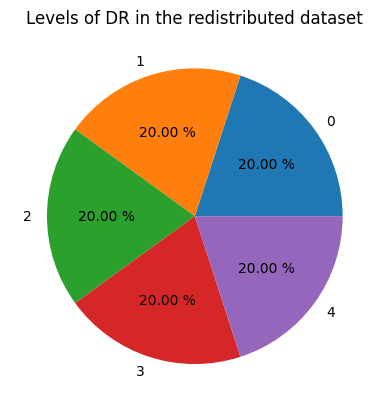

In [ ]:
dataset = orig_ds.groupby(['level']).sample(1000)
display(dataset.groupby('level')['image'].count())

plt.pie([dataset.loc[dataset['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the redistributed dataset")
plt.show()

In [ ]:
x_train, x_remain, y_train, y_remain = train_test_split(
    dataset['image'],
    dataset['level'],
    train_size=0.8,
    test_size=0.2,
    random_state=42
)

train_df = pd.DataFrame()
train_df['image'] = x_train
train_df['level'] = y_train

remain_df = pd.DataFrame()
remain_df['image'] = x_remain
remain_df['level'] = y_remain

x_val, x_test, y_val, y_test = train_test_split(
    remain_df['image'],
    remain_df['level'],
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

val_df = pd.DataFrame()
val_df['image'] = x_val
val_df['level'] = y_val

test_df = pd.DataFrame()
test_df['image'] = x_test
test_df['level'] = y_test

display(train_df.groupby(['level'])['image'].count())
display(train_df.head())
display(val_df.groupby(['level'])['image'].count())
display(val_df.head())
display(test_df.groupby(['level'])['image'].count())
display(test_df.head())

level
0    784
1    810
2    808
3    790
4    808
Name: image, dtype: int64

,image,level
2792,c0e509786f7f.png,4
325,187f6ccda87a.png,4
2384,a70d0f12a641.png,0
7464,4773_left.jpeg,3
32875,37008_right.jpeg,4


level
0    108
1     96
2     96
3    103
4     97
Name: image, dtype: int64

,image,level
16341,15923_left.jpeg,2
31844,35710_left.jpeg,3
2242,9dab2e6ba44b.png,2
2047,8ff863f8874f.png,1
981,462937ece243.png,0


level
0    108
1     94
2     96
3    107
4     95
Name: image, dtype: int64

,image,level
31397,35124_right.jpeg,3
19896,20342_left.jpeg,0
17997,18016_left.jpeg,2
22493,23771_right.jpeg,1
18676,18819_right.jpeg,3


In [ ]:
path_dict = {p:os.listdir(p)
              for p in ['/content/train_images', '/content/eyepacs_preprocess/eyepacs_preprocess']}
path_dict

{'/content/train_images': ['fca931da5c5e.png',
  '96d48b073f18.png',
  'f9d52509c571.png',
  '72c31aa48e2c.png',
  '6377e23928f6.png',
  '726dff37edc0.png',
  '09f6ab477654.png',
  'd74ccc796517.png',
  'd2cd47ed2c1d.png',
  'fca1a8738b8a.png',
  '8acffaf1f4b9.png',
  '80b5a9519aec.png',
  '85cc6d636898.png',
  '757572337fd0.png',
  'e499434242cc.png',
  '8185ce1cdcef.png',
  '3044022c6969.png',
  'b09101adb478.png',
  'd952dbfb0fe4.png',
  '8846b09384a4.png',
  'aa6242f9e08c.png',
  '60f15dd68d30.png',
  '0afdfe5f422c.png',
  'f2094a20b275.png',
  'cd48cfab4e44.png',
  '5257cb536da2.png',
  'd6df4fe492ec.png',
  'c57c164bca05.png',
  '174db0854291.png',
  'ad570b850a4f.png',
  '3ca8be3b40d6.png',
  'baaca2f7e1f0.png',
  'd51b3fe0fa1b.png',
  '084c02cf077f.png',
  'c446985355f1.png',
  'bc7bf19b84e3.png',
  '77b7b71ebcc3.png',
  'a66c3165876f.png',
  '64eb5a79dfdd.png',
  '04ac765f91a1.png',
  'bc23f74e14dd.png',
  'ee77763a6afb.png',
  '419406328dcd.png',
  'fa0c87bd75ce.png',
  '8676

In [ ]:
def clahe_image(path:str):
    # Load the image
    img = cv2.imread(path)
    # mask = cv2.imread('mask.png', 0)

    # Extract the green plane
    green_plane = img[:, :, 1]

    # Define the FA-CLAHE algorithm
    faclahe = cv2.createCLAHE(clipLimit=4.5, tileGridSize=(22, 22))

    # Apply the FA-CLAHE algorithm to the green plane
    faclahe_img = faclahe.apply(green_plane)

    # masked_img = cv2.bitwise_and(faclahe_img, faclahe_img, mask=mask)

    cv2.imwrite(path, faclahe_img)

In [ ]:
import cv2

splits = [
    (train_df, 'train'),
    (val_df, 'val'),
    (test_df, 'test')
]

for df, set_path in splits:
  df['level'] = df['level'].astype('str')
  ds_dict = df.to_dict(orient='index')
  set_path = os.path.join(DB_PATH, set_path)
  if not os.path.exists(set_path):
    os.mkdir(set_path)

  for datapoint in ds_dict.values():
    orig_path = ''
    for p, imgs in path_dict.items():
        orig_path = os.path.join(p, datapoint['image']) if datapoint['image'] in imgs else orig_path

    if orig_path == '':
      raise ValueError
    dest_path = os.path.join(set_path, datapoint['level'])
    
    if not os.path.exists(dest_path):
      os.mkdir(dest_path)
    
    dest_path = os.path.join(dest_path, datapoint['image'])

    move(orig_path, dest_path)
    clahe_image(dest_path)

    print(f'Moved {dest_path}')

Streaming output truncated to the last 5000 lines.
Moved ./DB/train/4/c0e509786f7f.png
Moved ./DB/train/4/187f6ccda87a.png
Moved ./DB/train/0/a70d0f12a641.png
Moved ./DB/train/3/4773_left.jpeg
Moved ./DB/train/4/37008_right.jpeg
Moved ./DB/train/2/11503_right.jpeg
Moved ./DB/train/4/21373_right.jpeg
Moved ./DB/train/4/4252_right.jpeg
Moved ./DB/train/2/16036_left.jpeg
Moved ./DB/train/2/37403_left.jpeg
Moved ./DB/train/3/26553_left.jpeg
Moved ./DB/train/1/13043_left.jpeg
Moved ./DB/train/3/43831_right.jpeg
Moved ./DB/train/3/17953_left.jpeg
Moved ./DB/train/2/da8900ac7f29.png
Moved ./DB/train/2/29274_left.jpeg
Moved ./DB/train/0/23902_left.jpeg
Moved ./DB/train/4/7164_left.jpeg
Moved ./DB/train/3/31712_right.jpeg
Moved ./DB/train/4/20d5fdd450ae.png
Moved ./DB/train/4/28434_right.jpeg
Moved ./DB/train/4/6c3745a222da.png
Moved ./DB/train/0/38831_left.jpeg
Moved ./DB/train/4/14084_right.jpeg
Moved ./DB/train/1/14664_right.jpeg
Moved ./DB/train/1/1520_left.jpeg
Moved ./DB/train/2/1594ca6c3

Using device cuda


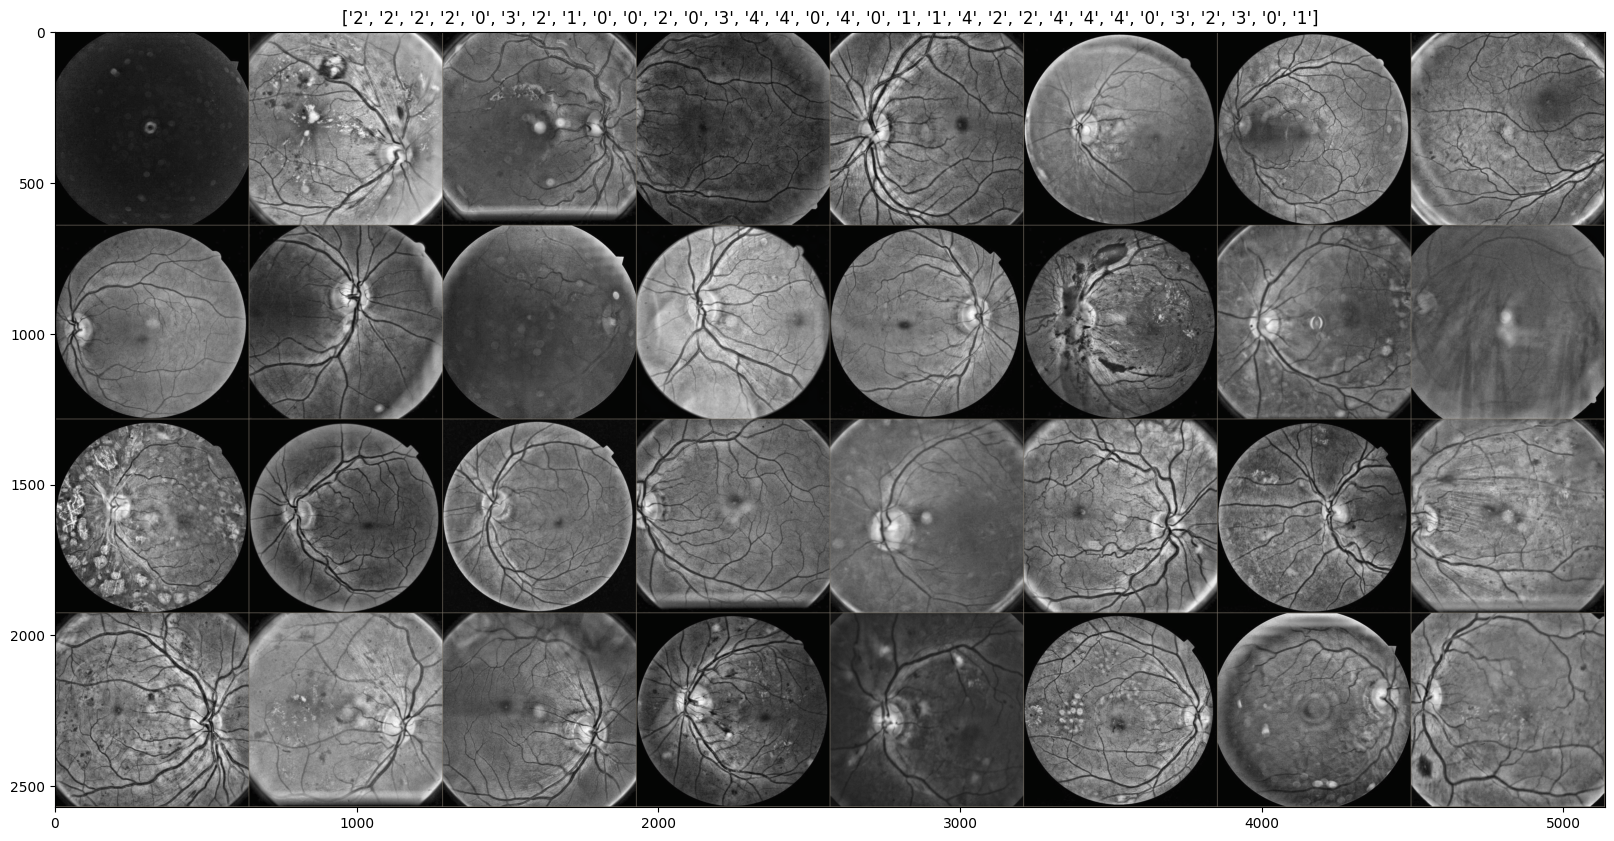

In [ ]:
# MobileNet Grading of Diabetic Retinopathy in PyTorch
from __future__ import print_function, division

from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sn
import pandas as pd
import numpy as np
import torchvision
import torch
import time
import copy
import os

cudnn.benchmark = True
plt.ion()   # interactive mode
## Load Data

IM_SIZE = 640
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

DATA_DIR = 'DB'
ds_splits = ['train', 'val', 'test']
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ds_splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ds_splits[:2]}

sample_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32,
                                        shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32,
                                        shuffle=False, num_workers=2)

dataset_sizes = {x: len(image_datasets[x]) for x in ds_splits}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using device {device}')

def imshow(inp, title=None, fig_size=(12,7)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=fig_size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], fig_size=(20,15))
## Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, losses=[], accuracies=[], starting_loss = float('inf')):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = starting_loss
    best_acc = 0.0

    try:
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward
                    # Track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                losses.append(epoch_loss)
                accuracies.append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Update best validation loss and model weights
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'New best model found with validation loss: {best_loss:.4f}')

            print()

    except KeyboardInterrupt:
        pass

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation loss: {best_loss:.4f} | Best validation accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return (best_loss, losses, accuracies, model)




def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(sample_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                title = f'predicted: {class_names[preds[j]]}, label: {labels[j]}'
                imshow(inputs.cpu().data[j], title=title, fig_size=(12,7))
                plt.show()
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
import datetime

TIME_STAMP = datetime.datetime.today().strftime('%d_%h_%y_%H_%M')
model_weights = models.MobileNet_V3_Small_Weights.DEFAULT

model_ft = models.mobilenet_v3_small(weights=model_weights)

for param in model_ft.features.parameters():
    param.requires_grad = False

num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 5)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.RMSprop(
    model_ft.parameters(), 
    lr=0.00001, 
    weight_decay=1e-5, 
    momentum=0.9
)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)


In [ ]:
warmup_epochs = 7
training_epochs = 25
FILENAME = f"{model_weights}_{warmup_epochs}_{training_epochs}_Grading_{TIME_STAMP}"
print(f'{FILENAME}')

print(f"Training on device {device}")


best_warmup_loss,w_losses, w_accuracies, model_ft = train_model(
    model = model_ft, 
    criterion = criterion, 
    optimizer = optimizer_ft, 
    scheduler = exp_lr_scheduler,
    num_epochs=warmup_epochs
)

for param in model_ft.features.parameters():
    param.requires_grad = True

_, f_losses, f_accuracies, model_ft = train_model(
    model = model_ft, 
    criterion = criterion, 
    optimizer = optimizer_ft, 
    scheduler = exp_lr_scheduler,
    num_epochs=training_epochs,
    starting_loss = best_warmup_loss
)

MobileNet_V3_Small_Weights.IMAGENET1K_V1_14_18_Grading_16_May_23_14_35
Training on device cuda
Epoch 1/14
----------
train Loss: 1.3944 Acc: 0.3808
val Loss: 1.6084 Acc: 0.3060
New best model found with validation loss: 1.6084

Epoch 2/14
----------
train Loss: 1.2933 Acc: 0.4328
val Loss: 1.6486 Acc: 0.3280

Epoch 3/14
----------
train Loss: 1.2618 Acc: 0.4495
val Loss: 1.4280 Acc: 0.3700
New best model found with validation loss: 1.4280

Epoch 4/14
----------
train Loss: 1.2481 Acc: 0.4460
val Loss: 1.3687 Acc: 0.3780
New best model found with validation loss: 1.3687

Epoch 5/14
----------
train Loss: 1.2266 Acc: 0.4587
val Loss: 1.3939 Acc: 0.3840

Epoch 6/14
----------
train Loss: 1.2196 Acc: 0.4620
val Loss: 1.3503 Acc: 0.3960
New best model found with validation loss: 1.3503

Epoch 7/14
----------
train Loss: 1.2031 Acc: 0.4745
val Loss: 1.2595 Acc: 0.4180
New best model found with validation loss: 1.2595

Epoch 8/14
----------
train Loss: 1.1911 Acc: 0.4755
val Loss: 1.2341 Acc:

In [ ]:
if not os.path.exists('models'):
  os.mkdir('models')

MODEL_PATH = os.path.sep.join(['models', f'{FILENAME}.pt'])
torch.save(model_ft.state_dict(), MODEL_PATH)

In [ ]:
visualize_model(model_ft)
y_pred = []
y_true = []
# iterate over test data
print("[INFO] Iterating predictions")

device = torch.device("cpu")
model_ft = model_ft.to(device)
model_ft.eval()

for inputs, labels in test_dataloader:
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
                
print("[INFO] Finished iterating predictions")
print("[INFO] Building Matrix")
# constant for classes
classes = ('No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR')

def get_matrix(cfm: np.ndarray, pct:True):
        if pct:
                return cfm / np.sum(cfm, axis=1)
        else:
                return cfm

if not os.path.exists('output'):
  os.mkdir('output')
OUTPATH = os.path.sep.join(['output',f'{FILENAME}'])
if not os.path.exists(OUTPATH):
        os.mkdir(OUTPATH)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
for pct in (False, True):
        df_cm = pd.DataFrame(get_matrix(cfm=cf_matrix,pct=pct), index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True, fmt='g')
        cm_path = os.path.sep.join([OUTPATH, f'confusion_matrix_pct_{pct}.png'])
        plt.savefig(cm_path)

In [ ]:
import shutil

shutil.copy(MODEL_PATH, '/gdrive/MyDrive/Models')